# Sentiment Classification

## inspect data

In [2]:
import pandas as pd

# New cell at index 0

path = r"../data/book_processed_output.csv"
df = pd.read_csv(path)

# Try common column names first, then try to auto-detect a 1-5 numeric column.
common = {"rating", "review_rating", "stars", "review_stars", "score"}
col = next((c for c in df.columns if c.lower() in common), None)

if col is None:
    for c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce").dropna()
        if not s.empty and s.isin([1, 2, 3, 4, 5]).all():
            col = c
            break

if col is None:
    raise ValueError(f"Couldn't find a 1-5 rating column. Available columns: {list(df.columns)}")

counts = pd.to_numeric(df[col], errors="coerce").dropna().astype(int).value_counts().reindex(range(1, 6), fill_value=0).sort_index()
print(f"Rating counts for column '{col}':\n{counts}")

Rating counts for column 'rating':
rating
1      569
2     1594
3     5226
4    13137
5    21807
Name: count, dtype: int64


## Count rating

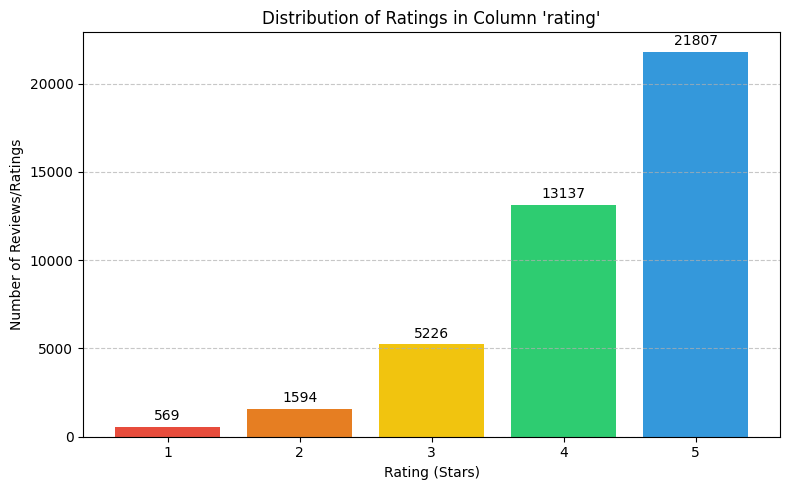

In [ ]:
import matplotlib.pyplot as plt
# --- Visualization Code ---
plt.figure(figsize=(8, 5))
bar_colors = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#3498db'] # Colors for 1 to 5 stars
bars = plt.bar(counts.index, counts.values, color=bar_colors)

plt.xlabel("Rating (Stars)")
plt.ylabel("Number of Reviews/Ratings")
plt.title(f"Distribution of Ratings in Column '{col}'")
plt.xticks(counts.index) # Ensure ticks are exactly at 1, 2, 3, 4, 5

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(counts.values) * 0.01, int(yval), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

## Define Class

In [4]:
# Remap labels to 3-class sentiment: Negative (1,2) -> 0, Mixed (3) -> 1, Positive (4,5) -> 2
print("=" * 120)
print("REMAPPING LABELS TO 3-CLASS SENTIMENT")
print("=" * 120)

def remap_labels(y):
    """
    Remap 5-class ratings (1-5) to 3-class sentiment:
    1, 2 -> 0 (Negative)
    3 -> 1 (Mixed)
    4, 5 -> 2 (Positive)
    """
    return np.array([0 if rating in [1, 2] else (1 if rating == 3 else 2) for rating in y])

# Add remapped labels to dataframe
df['sentiment'] = df['rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2))

# Show mapping
print("\nLabel Remapping:")
print("  1, 2 stars -> 0 (Negative)")
print("  3 stars    -> 1 (Mixed)")
print("  4, 5 stars -> 2 (Positive)")

print("\nOverall Sentiment Distribution:")
sentiment_counts = df['sentiment'].value_counts().sort_index()
print(f"  Negative (0): {sentiment_counts.get(0, 0):,} reviews")
print(f"  Mixed (1):    {sentiment_counts.get(1, 0):,} reviews")
print(f"  Positive (2): {sentiment_counts.get(2, 0):,} reviews")

print("=" * 120)

REMAPPING LABELS TO 3-CLASS SENTIMENT

Label Remapping:
  1, 2 stars -> 0 (Negative)
  3 stars    -> 1 (Mixed)
  4, 5 stars -> 2 (Positive)

Overall Sentiment Distribution:
  Negative (0): 2,163 reviews
  Mixed (1):    5,226 reviews
  Positive (2): 35,838 reviews


## Class distribution

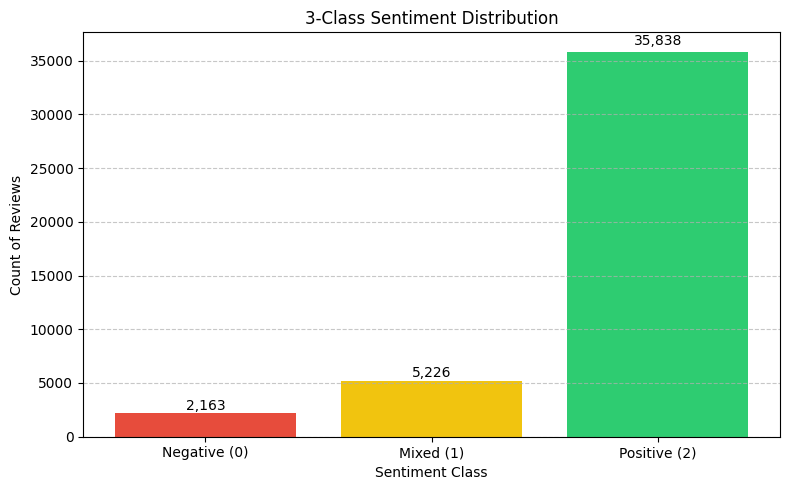

In [5]:
plt.figure(figsize=(8, 5))

# Data to plot
ratings = sentiment_counts.index
counts = sentiment_counts.values
sentiment_labels = ["Negative (0)", "Mixed (1)", "Positive (2)"]
# Define colors for better representation (Negative/Red, Mixed/Yellow, Positive/Green)
bar_colors = ['#e74c3c', '#f1c40f', '#2ecc71']

bars = plt.bar(ratings, counts, color=bar_colors)

# Set X-axis labels to sentiment names
plt.xticks(ratings, sentiment_labels)

plt.xlabel("Sentiment Class")
plt.ylabel("Count of Reviews")
plt.title("3-Class Sentiment Distribution")

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    # Position text slightly above the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.01, f'{int(yval):,}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

### data is very imbalance
we will use SMOTE technique for oversamplling the minority lable

## import lib

In [6]:
# Required imports for 3-class sentiment classification
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

C:\Users\kenpo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Split train/test

In [7]:
print("=" * 120)
print("3-CLASS SENTIMENT CLASSIFICATION - COMBINED ALL BOOKS (80/20 Train/Test Split)")
print("=" * 120)

# Prepare data with sentiment labels (Negative=0, Mixed=1, Positive=2)
X_sentiment = df['lemmatized_text'].values # using lemmatized text
y_sentiment = df['sentiment'].astype(int).values

print(f"\n1. Data Summary:")
print(f"   Total reviews: {len(X_sentiment):,}")
print(f"   Sentiment distribution:")
print(f"     Negative (1-2★): {(y_sentiment == 0).sum():,} reviews")
print(f"     Mixed (3★):      {(y_sentiment == 1).sum():,} reviews")
print(f"     Positive (4-5★): {(y_sentiment == 2).sum():,} reviews")

# Split into 80/20 train/test with stratification
print(f"\n2. Splitting data (80/20 with stratification)...")
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    X_sentiment, y_sentiment, test_size=0.2, random_state=42, stratify=y_sentiment
)

print(f"   Training set: {len(X_train_sent):,} reviews")
print(f"   Test set: {len(X_test_sent):,} reviews")
print(f"   Training distribution:")
print(f"     Negative: {(y_train_sent == 0).sum():,} | Mixed: {(y_train_sent == 1).sum():,} | Positive: {(y_train_sent == 2).sum():,}")
print(f"   Test distribution:")
print(f"     Negative: {(y_test_sent == 0).sum():,} | Mixed: {(y_test_sent == 1).sum():,} | Positive: {(y_test_sent == 2).sum():,}")


3-CLASS SENTIMENT CLASSIFICATION - COMBINED ALL BOOKS (80/20 Train/Test Split)

1. Data Summary:
   Total reviews: 43,227
   Sentiment distribution:
     Negative (1-2★): 2,163 reviews
     Mixed (3★):      5,226 reviews
     Positive (4-5★): 35,838 reviews

2. Splitting data (80/20 with stratification)...
   Training set: 34,581 reviews
   Test set: 8,646 reviews
   Training distribution:
     Negative: 1,730 | Mixed: 4,181 | Positive: 28,670
   Test distribution:
     Negative: 433 | Mixed: 1,045 | Positive: 7,168


## SMOTE oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("=" * 120)
print("SBERT EMBEDDING AND SMOTE RESAMPLING")
print("=" * 120)

# 1. Load SBERT model
print(f"\n1. Loading Sentence-BERT model (all-MiniLM-L6-v2)...")
model_sent = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Generate embeddings for training set (Original)
print(f"2. Generating original embeddings for training set ({len(X_train_sent):,} reviews)...")
# Note: setting show_progress_bar=True for better tracking
embeddings_train_sent_orig = model_sent.encode(X_train_sent, show_progress_bar=True, batch_size=32)
print(f"   ✓ Training Embeddings Shape: {embeddings_train_sent_orig.shape}")

# 3. Generate embeddings for test set (Unresampled)
print(f"3. Generating embeddings for test set ({len(X_test_sent):,} reviews)...")
embeddings_test_sent = model_sent.encode(X_test_sent, show_progress_bar=True, batch_size=32)
print(f"   ✓ Test Embeddings Shape: {embeddings_test_sent.shape}")


# 4. Apply SMOTE to training embeddings
print(f"\n4. Applying SMOTE to training embeddings...")

# Initialize SMOTE to balance the classes
# 'auto' samples all minority classes up to the size of the majority class.
sm = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5) 

# Fit and resample the training embeddings and labels
embeddings_train_sent_resampled, y_train_sent_resampled = sm.fit_resample(
    embeddings_train_sent_orig, y_train_sent
)

print(f"   Original Training Distribution: {Counter(y_train_sent)}")
print(f"   Resampled Training Distribution: %s" % Counter(y_train_sent_resampled))
print(f"   ✓ Resampled Training Embeddings Shape: {embeddings_train_sent_resampled.shape}")

print("\n" + "=" * 120)
print("READY FOR TRAINING: Use embeddings_train_sent_resampled and y_train_sent_resampled.")
print("=" * 120)

SBERT EMBEDDING AND SMOTE RESAMPLING

1. Loading Sentence-BERT model (all-MiniLM-L6-v2)...
2. Generating original embeddings for training set (34,581 reviews)...


Batches: 100%|██████████| 1081/1081 [02:22<00:00,  7.61it/s]


   ✓ Training Embeddings Shape: (34581, 384)
3. Generating embeddings for test set (8,646 reviews)...


Batches: 100%|██████████| 271/271 [00:36<00:00,  7.52it/s]


   ✓ Test Embeddings Shape: (8646, 384)

4. Applying SMOTE to training embeddings...
   Original Training Distribution: Counter({np.int64(2): 28670, np.int64(1): 4181, np.int64(0): 1730})
   Resampled Training Distribution: Counter({np.int64(2): 28670, np.int64(1): 28670, np.int64(0): 28670})
   ✓ Resampled Training Embeddings Shape: (86010, 384)

READY FOR TRAINING: Use embeddings_train_sent_resampled and y_train_sent_resampled.


### oversampling embedded distribution

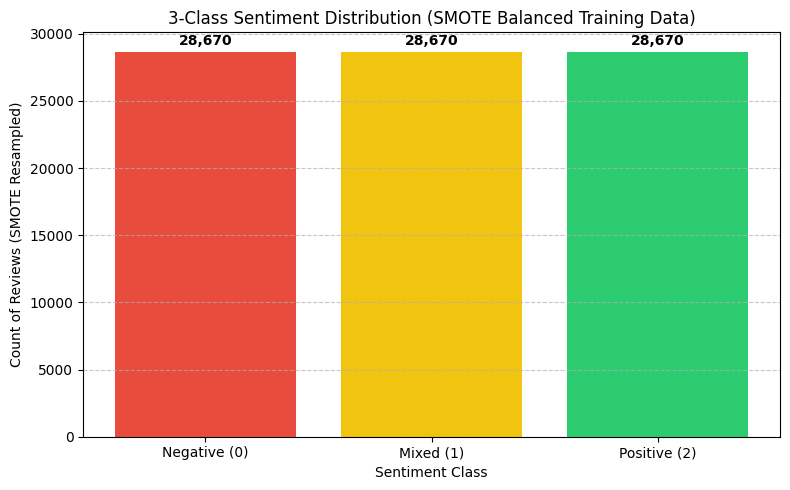

In [11]:
# Assuming y_train_sent_resampled is available from the SMOTE cell

# Get the counts of the resampled labels
resampled_counts = Counter(y_train_sent_resampled)
counts_series = pd.Series(resampled_counts).sort_index()

# Visualization for 3-class sentiment distribution (SMOTE)
plt.figure(figsize=(8, 5))

# Data to plot
ratings = counts_series.index
counts = counts_series.values
sentiment_labels = ["Negative (0)", "Mixed (1)", "Positive (2)"]
# Define colors (Negative/Red, Mixed/Yellow, Positive/Green)
bar_colors = ['#e74c3c', '#f1c40f', '#2ecc71']

bars = plt.bar(ratings, counts, color=bar_colors)

# Set X-axis labels to sentiment names
plt.xticks(ratings, sentiment_labels)

plt.xlabel("Sentiment Class")
plt.ylabel("Count of Reviews (SMOTE Resampled)")
plt.title("3-Class Sentiment Distribution (SMOTE Balanced Training Data)")

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    # Position text slightly above the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.01, f'{int(yval):,}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Assuming the following variables are available from prior cells:
# X_train_sent, X_test_sent, y_train_sent, y_test_sent (from train_test_split)
# embeddings_train_sent_resampled, y_train_sent_resampled, embeddings_test_sent (from SMOTE cell)


# Load SBERT model
print(f"\n3. Loading Sentence-BERT model...")
model_sent = SentenceTransformer('all-MiniLM-L6-v2')
print(f"   ✓ Model loaded successfully (384-dimensional embeddings)")

# --- CRITICAL CHANGE 1: SKIP RE-EMBEDDING THE TRAINING SET ---
# The SMOTE cell already created the RESAMPLED features. 
# We'll use the final resampled variables created there: 
# embeddings_train_sent_resampled
# y_train_sent_resampled

# We only need to ensure the test embeddings are ready if the SBERT/SMOTE cell 
# was skipped, but since you are using SBERT in your previous code, 
# we'll keep the test embedding generation step for completeness.

# Generate embeddings for test set
print(f"\n4. Generating embeddings for test set...")
print(f"   Processing {len(X_test_sent):,} reviews...")
embeddings_test_sent = model_sent.encode(X_test_sent, show_progress_bar=True, batch_size=32)
print(f"   ✓ Shape: {embeddings_test_sent.shape}")

# Train Random Forest classifier
print(f"\n5. Training Random Forest classifier on SBERT embeddings...")
print(f"   Using **{len(y_train_sent_resampled):,} RESAMPLED** training samples.")
classifier_sent = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)

# --- CRITICAL CHANGE 2: USE RESAMPLED DATA FOR FITTING ---
# Use the resampled features and labels for training
classifier_sent.fit(embeddings_train_sent_resampled, y_train_sent_resampled) 
print(f"   ✓ Model trained successfully")

# Make predictions
print(f"\n6. Making predictions on test set...")
y_pred_sent = classifier_sent.predict(embeddings_test_sent)
accuracy_sent = accuracy_score(y_test_sent, y_pred_sent)
print(f"   ✓ Predictions completed")

# Display results
print(f"\n" + "=" * 120)
print(f"RESULTS - 3-CLASS SENTIMENT CLASSIFICATION (SMOTE-BALANCED TRAINING)")
print(f"=" * 120)
print(f"\nAccuracy (Overall): {accuracy_sent:.4f} ({accuracy_sent*100:.2f}%)\n")

print(f"Classification Report (Check Minority Classes F1-Score!):")
# Use the original, unresampled test labels (y_test_sent) for evaluation
print(classification_report(y_test_sent, y_pred_sent, labels=[0, 1, 2], target_names=['Negative', 'Mixed', 'Positive'], digits=4))

# Confusion Matrix
cm_sent = confusion_matrix(y_test_sent, y_pred_sent, labels=[0, 1, 2])
print(f"Confusion Matrix (Test Set):")
print(f"     Predicted Negative   Predicted Mixed   Predicted Positive")
print(f"Actual Negative     {cm_sent[0, 0]:>6}              {cm_sent[0, 1]:>6}             {cm_sent[0, 2]:>6}")
print(f"Actual Mixed        {cm_sent[1, 0]:>6}              {cm_sent[1, 1]:>6}             {cm_sent[1, 2]:>6}")
print(f"Actual Positive     {cm_sent[2, 0]:>6}              {cm_sent[2, 1]:>6}             {cm_sent[2, 2]:>6}")

print("\n" + "=" * 120)


3. Loading Sentence-BERT model...
   ✓ Model loaded successfully (384-dimensional embeddings)

4. Generating embeddings for test set...
   Processing 8,646 reviews...


Batches: 100%|██████████| 271/271 [00:33<00:00,  8.09it/s]


   ✓ Shape: (8646, 384)

5. Training Random Forest classifier on SBERT embeddings...
   Using **86,010 RESAMPLED** training samples.
   ✓ Model trained successfully

6. Making predictions on test set...
   ✓ Predictions completed

RESULTS - 3-CLASS SENTIMENT CLASSIFICATION (SMOTE-BALANCED TRAINING)

Accuracy (Overall): 0.7680 (76.80%)

Classification Report (Check Minority Classes F1-Score!):
              precision    recall  f1-score   support

    Negative     0.2838    0.2910    0.2873       433
       Mixed     0.2574    0.2737    0.2653      1045
    Positive     0.8783    0.8689    0.8736      7168

    accuracy                         0.7680      8646
   macro avg     0.4732    0.4778    0.4754      8646
weighted avg     0.7735    0.7680    0.7707      8646

Confusion Matrix (Test Set):
     Predicted Negative   Predicted Mixed   Predicted Positive
Actual Negative        126                  82                225
Actual Mixed           121                 286                638

In [13]:

# Load SBERT model
print(f"\n3. Loading Sentence-BERT model...")
model_sent = SentenceTransformer('all-MiniLM-L6-v2')
print(f"   ✓ Model loaded successfully (384-dimensional embeddings)")

# Generate embeddings for training set
print(f"\n4. Generating embeddings for training set...")
print(f"   Processing {len(X_train_sent):,} reviews...")
embeddings_train_sent = model_sent.encode(X_train_sent, show_progress_bar=True, batch_size=32)
print(f"   ✓ Shape: {embeddings_train_sent.shape}")

# Generate embeddings for test set
print(f"\n5. Generating embeddings for test set...")
print(f"   Processing {len(X_test_sent):,} reviews...")
embeddings_test_sent = model_sent.encode(X_test_sent, show_progress_bar=True, batch_size=32)
print(f"   ✓ Shape: {embeddings_test_sent.shape}")

# Train Random Forest classifier
print(f"\n6. Training Random Forest classifier on SBERT embeddings...")
classifier_sent = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
classifier_sent.fit(embeddings_train_sent, y_train_sent)
print(f"   ✓ Model trained successfully")

# Make predictions
print(f"\n7. Making predictions on test set...")
y_pred_sent = classifier_sent.predict(embeddings_test_sent)
accuracy_sent = accuracy_score(y_test_sent, y_pred_sent)
print(f"   ✓ Predictions completed")

# Display results
print(f"\n" + "=" * 120)
print(f"RESULTS - 3-CLASS SENTIMENT CLASSIFICATION (COMBINED)")
print(f"=" * 120)
print(f"\nAccuracy: {accuracy_sent:.4f} ({accuracy_sent*100:.2f}%)\n")

print(f"Classification Report:")
print(classification_report(y_test_sent, y_pred_sent, labels=[0, 1, 2], 
                          target_names=['Negative', 'Mixed', 'Positive'], digits=4))

# Confusion Matrix
cm_sent = confusion_matrix(y_test_sent, y_pred_sent, labels=[0, 1, 2])
print(f"Confusion Matrix:")
print(f"                Predicted Negative  Predicted Mixed  Predicted Positive")
print(f"Actual Negative     {cm_sent[0, 0]:>6}              {cm_sent[0, 1]:>6}             {cm_sent[0, 2]:>6}")
print(f"Actual Mixed        {cm_sent[1, 0]:>6}              {cm_sent[1, 1]:>6}             {cm_sent[1, 2]:>6}")
print(f"Actual Positive     {cm_sent[2, 0]:>6}              {cm_sent[2, 1]:>6}             {cm_sent[2, 2]:>6}")

print("\n" + "=" * 120)


3. Loading Sentence-BERT model...
   ✓ Model loaded successfully (384-dimensional embeddings)

4. Generating embeddings for training set...
   Processing 34,581 reviews...


Batches: 100%|██████████| 1081/1081 [02:11<00:00,  8.21it/s]


   ✓ Shape: (34581, 384)

5. Generating embeddings for test set...
   Processing 8,646 reviews...


Batches: 100%|██████████| 271/271 [00:33<00:00,  8.13it/s]


   ✓ Shape: (8646, 384)

6. Training Random Forest classifier on SBERT embeddings...
   ✓ Model trained successfully

7. Making predictions on test set...
   ✓ Predictions completed

RESULTS - 3-CLASS SENTIMENT CLASSIFICATION (COMBINED)

Accuracy: 0.8291 (82.91%)

Classification Report:
              precision    recall  f1-score   support

    Negative     0.5000    0.0023    0.0046       433
       Mixed     0.4000    0.0019    0.0038      1045
    Positive     0.8294    0.9996    0.9066      7168

    accuracy                         0.8291      8646
   macro avg     0.5765    0.3346    0.3050      8646
weighted avg     0.7610    0.8291    0.7523      8646

Confusion Matrix:
                Predicted Negative  Predicted Mixed  Predicted Positive
Actual Negative          1                   0                432
Actual Mixed             1                   2               1042
Actual Positive          0                   3               7165

